# **Neural Machine Translation**

### **English to Japanese**


# **Introduction**

Our primary objective is to develop a Transformer-based Neural Machine Translation system for converting Japanese sentences into English sentences.

## **Dataset**


In [6]:
ANKI_LEXICON_PATH = '/content/dataset/eng_jpn.txt'
KYOTO_LEXICON_PATH = '/content/dataset/kyoto_lexicon.csv'

## **Hyperparamters**

The below are the Hyperparamters for our model. 


In [7]:
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'


In [8]:
BATCH_SIZE = 20
EPOCHS = 50

D_MODEL = 512
HEADS = 8
N = 6

# **Library Imports and Device Configuration**

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import torchtext
from torchtext import data
from torchtext.data import Field, BucketIterator, TabularDataset
from sklearn.model_selection import train_test_split
import math
import copy
from datetime import datetime
from nltk.translate.bleu_score import sentence_bleu

if torch.cuda.is_available():
    device = 'cuda:0'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


## **Preprocessing**

We employ the spaCy library for English and Japanese text tokenization in our preprocessing stage. spaCy is a powerful open-source Python library designed for NLP tasks, seamlessly integrating with popular AI frameworks. It accurately segments Japanese text into meaningful word units, despite the absence of spaces. Installing spaCy and other necessary dependencies is crucial for preprocessing.

In [9]:
!pip install torchtext==0.6.0
!pip download spacy
!pip install sudachipy sudachidict_core
!pip install -U spacy
!pip install spacy[ja]
!pip install spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  File was already downloaded /content/spacy-3.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  File was already downloaded /content/spacy_legacy-3.0.12-py2.py3-none-any.whl
  File was already downloaded /content/spacy_loggers-1.0.4-py3-none-any.whl
  File was already downloaded /content/murmurhash-1.0.9-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  File was already downloaded /content/cymem-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  File was already downloaded /content/preshed-3.0.8-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  File was already downloaded /content/thinc-8.1.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  File was

In [11]:
anki_dataset_df = pd.read_csv(ANKI_LEXICON_PATH,sep='\t',names=['Japanese','English']) 

In [12]:
kyoto_lexicon_df = pd.read_csv(KYOTO_LEXICON_PATH, error_bad_lines=False)

<ipython-input-12-f1baa3a726a5>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  kyoto_lexicon_df = pd.read_csv(KYOTO_LEXICON_PATH, error_bad_lines=False)
Skipping line 2738: expected 3 fields, saw 4
Skipping line 2787: expected 3 fields, saw 4
Skipping line 2843: expected 3 fields, saw 4
Skipping line 2850: expected 3 fields, saw 4
Skipping line 2853: expected 3 fields, saw 4
Skipping line 2894: expected 3 fields, saw 4
Skipping line 3135: expected 3 fields, saw 4
Skipping line 3179: expected 3 fields, saw 4
Skipping line 3247: expected 3 fields, saw 4
Skipping line 3312: expected 3 fields, saw 4
Skipping line 3504: expected 3 fields, saw 4



In [13]:
JA = spacy.blank('ja')
EN = spacy.load("en_core_web_sm")

In [14]:
def tokenize_ja(sentence):
    return [tok.text for tok in JA.tokenizer(sentence)]

def tokenize_en(sentence):
    return [tok.text for tok in EN.tokenizer(sentence)]

In [15]:
JA_TEXT = Field(tokenize=tokenize_ja) 
EN_TEXT = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>') 

In [16]:
JA_TEXT

Merging the dataset here. (Both Kyoto_lexicon and anki_dataset)

In [17]:
frames = [kyoto_lexicon_df, anki_dataset_df]

In [18]:
merged_dataset_df = pd.concat(frames)

In [19]:
merged_dataset_df.head()

,日本語,英語,Unnamed: 2,Japanese,English
0,102世吉田日厚貫首,"the 102nd head priest, Nikko TOSHIDA",NaN,NaN,NaN
1,1月15日：成人祭、新年祭,"15th January: Seijin-sai (Adult Festival), the...",NaN,NaN,NaN
2,1月3日：家運隆盛、商売繁盛祈願祭,3rd January: Prayer Festival for the prosperit...,NaN,NaN,NaN
3,1月7日：七種粥神事,7th January: Nanakusa-gayu shinji (a divine se...,NaN,NaN,NaN
4,21世紀COEプログラム,The 21st Century Center Of Excellence Program,NaN,NaN,NaN


## **Dataset Split**

In the subsequent steps, we will split our dataset into three separate CSV files according to the following distribution: 60% for training, 20% for validation, and 20% for testing.

In [20]:
# train, val, test = train_val_test_split(kyoto_lexicon_df, test_size=0.3)
train, val, test = np.split(merged_dataset_df.sample(frac=1), [int(.6*len(merged_dataset_df)), int(.8*len(merged_dataset_df))])
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False) 
test.to_csv('test.csv', index=False) 

In [21]:
data_fields = [('Japanese', JA_TEXT), ('English', EN_TEXT)]

train, val, test = TabularDataset.splits(path='./',
                        train='train.csv', 
                        validation='val.csv',
                        test = 'test.csv',
                        format='csv',
              
                        fields = data_fields )

In [22]:
train

In [23]:
JA_TEXT.build_vocab(train, val) 
EN_TEXT.build_vocab(train, val) 

In [24]:
train_iter = BucketIterator(
    train,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.English),
    shuffle=True
)

In [25]:
batch = next(iter(train_iter)) 

In [26]:
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.Japanese))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.English) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

In [27]:
train_iter = MyIterator(
    train,
    batch_size=1300,
    device=0,
    repeat=False,
    sort_key=lambda x: (len(x.Japanese), len(x.English)),
    batch_size_fn=batch_size_fn,
    train=True,
    shuffle=True
)

# **Transformer Model**

## **Introduction**

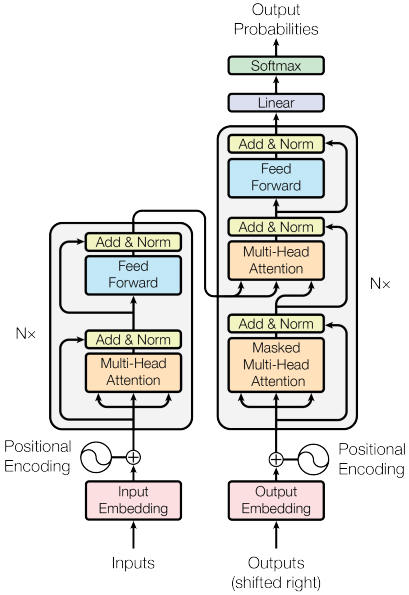

Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalization. 

Recurrent neural networks are very slow to train and without LSTM the model is not very accurate. But with LSTM, the model makes it much slower to train.

First for out baseline model we used seq2seq as our baseline model but since doesn't do parallel computing and no GPU is used we have switched to transformer model which is much faster than the seq2seq model 

In the seq2seq model the words are passed to the encoder sequentially and there is no use of GPU there. So in order to do parallel computing for the language translation we went with transformers.


First the tokens are passed through the standard embedding layer. Next, as the model has no recurrent it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a positional embedding layer. The next function after the Enbedder is the PositionEncoder.

In [29]:
import torch.nn as nn

def Embedder(vocab_size, d_model):
    """
    Create an embedding layer.

    Args:
        vocab_size (int): The size of the vocabulary.
        d_model (int): The dimensionality of the embedding.

    Returns:
        nn.Embedding: The embedding layer.
    """
    embedding = nn.Embedding(vocab_size, d_model)
    return embedding

# Usage example:
vocab_size = 10000
d_model = 256
embedder = Embedder(vocab_size, d_model)
print(embedder)

Embedding(10000, 256)


To ensure our model considers the order of the sequence without recurrence or convolution, we incorporate positional encoding. By using the formula (PE(pos, 2i) = sin(pos / 10000^(2i/d_model)) and PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model)), where pos represents token position and d_model is set to 512, we provide the model with positional information. This encoding enables the model to utilize the relative or absolute position of tokens within the sequence.

In [31]:
import math

def PositionalEncoder(d_model, max_seq_len=80):
    # Create a positional encoding matrix 'pe' with values dependent on position and i
    pe = torch.zeros(max_seq_len, d_model)
    for pos in range(max_seq_len):
        for i in range(0, d_model, 2):
            pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
            pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))

    pe = pe.unsqueeze(0)
    pe = pe.to(device)  # Assuming 'device' is defined elsewhere
    
    def forward(x):
        # Scale the embeddings by a square root of the model dimension
        x = x * math.sqrt(d_model)

        # Add the positional encoding constant to the embeddings
        seq_len = x.size(1)
        x = x + pe[:, :seq_len].detach()
        return x

    return forward


The input mask, called input_msk, has a shape identical to that of the input sentence. It assigns a value of 1 to non-<pad> tokens in the source sentence and 0 to <pad> tokens. Its purpose is to mask the multi-head attention mechanisms in the encoder layers. These mechanisms compute and apply attention across the source sentence, ensuring that the model disregards <pad> tokens that lack valuable information.

In [32]:
def create_masks(input_seq, target_seq, input_pad_idx, target_pad_idx, device):
    input_msk = (input_seq != input_pad_idx).unsqueeze(1)
    target_msk = (target_seq != target_pad_idx).unsqueeze(1)
    
    size = target_seq.size(1)
    nopeak_mask = np.triu(np.ones((1, size, size)), k=1).astype(np.uint8)
    nopeak_mask = torch.tensor(nopeak_mask == 0).to(device)
    target_msk = target_msk & nopeak_mask
    
    return input_msk, target_msk

We first pass the input sentence and its mask into the multi-head attention layer, then perform dropout on it,  pass it through a Layer Normalization layer. 

The mutli head attention layer is used by the encoder layer to attend to the input sentence, i.e. it is calculating and applying attention over itself instead of another sequence.

Multi head attention means many attention vectors will be created for each word and the Wz weight will choose which attention vector to take. (Multiple attention vector for one word)
And the rest of the things in the Attention model are normal like Feed Forward Neural Network.


In [34]:
def multi_head_attention(heads, d_model, dropout=0.1):
    def attention(q, k, v, d_k, mask=None, dropout=None):
        # Attention calculation implementation goes here
        pass

    def multi_head_attention_forward(self, q, k, v, mask=None):
        bs = q.size(0)

        # Perform linear operation and split into h heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        # Transpose to get dimensions bs * h * sl * d_model
        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)

        # Calculate attention using the defined `attention` function
        scores = attention(q, k, v, self.d_k, mask, self.dropout)

        # Concatenate heads and put through the final linear layer
        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        output = self.out(concat)

        return output

    return multi_head_attention_forward


In [36]:
def my_attention(my_q, my_k, my_v, my_d_k, my_mask=None, my_dropout=None):
    scores = torch.matmul(my_q, my_k.transpose(-2, -1)) /  math.sqrt(my_d_k)
    if my_mask is not None:
        my_mask = my_mask.unsqueeze(1)
        scores = scores.masked_fill(my_mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)

    if my_dropout is not None:
        scores = my_dropout(scores)

    output = torch.matmul(scores, my_v)
    return output


In [38]:
def FeedForward(d_model, d_ff=2048, dropout=0.1):
    class FeedForward(nn.Module):
        def __init__(self):
            super().__init__()
            self.linear_1 = nn.Linear(d_model, d_ff)
            self.dropout = nn.Dropout(dropout)
            self.linear_2 = nn.Linear(d_ff, d_model)

        def forward(self, x):
            x = self.dropout(F.relu(self.linear_1(x)))
            x = self.linear_2(x)
            return x

    return FeedForward()

In [40]:
def norm(d_model, eps=1e-6):
    def norm_forward(x):
        alpha = nn.Parameter(torch.ones(d_model))
        bias = nn.Parameter(torch.zeros(d_model))
        norm = alpha * (x - x.mean(dim=-1, keepdim=True)) / (x.std(dim=-1, keepdim=True) + eps) + bias
        return norm

    return norm_forward

The decoder generates predicted tokens for the target sentence based on the encoded representation of the source sentence. We calculate the loss by comparing the predicted tokens with the actual tokens in the target sentence. The gradients of the parameters are computed using the loss, and the Adam optimizer is used to update the weights and improve predictions.

In [50]:
import copy

def EncoderLayer(d_model, heads, dropout=0.1):
    def encoder_layer_forward(x, mask):
        norm_1 = nn.LayerNorm(d_model)
        norm_2 = nn.LayerNorm(d_model)
        attn = multi_head_attention(heads, d_model)
        ff = FeedForward(d_model)
        dropout_1 = nn.Dropout(dropout)
        dropout_2 = nn.Dropout(dropout)

        x2 = norm_1(x)
        x = x + dropout_1(attn(x2, x2, x2, mask))
        x2 = norm_2(x)
        x = x + dropout_2(ff(x2))

        return x

    return encoder_layer_forward


def DecoderLayer(d_model, heads, dropout=0.1):
    def decoder_layer_forward(x, e_outputs, src_mask, trg_mask):
        norm_1 = nn.LayerNorm(d_model)
        norm_2 = nn.LayerNorm(d_model)
        norm_3 = nn.LayerNorm(d_model)
        dropout_1 = nn.Dropout(dropout)
        dropout_2 = nn.Dropout(dropout)
        dropout_3 = nn.Dropout(dropout)
        attn_1 = multi_head_attention(heads, d_model)
        attn_2 = multi_head_attention(heads, d_model)
        ff = FeedForward(d_model)

        x2 = norm_1(x)
        x = x + dropout_1(attn_1(x2, x2, x2, trg_mask))
        x2 = norm_2(x)
        x = x + dropout_2(attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = norm_3(x)
        x = x + dropout_3(ff(x2))

        return x

    return decoder_layer_forward


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

The decoder is similar to encoder, however it has two multi-head attention layers. A *masked multi-head attention layer* over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value.

In [52]:
import torch.nn as nn

def Encoder(vocab_size, d_model, N, heads):
    def encoder_forward(src, mask):
        embed = embedder(vocab_size, d_model)
        pe = PositionalEncoder(d_model)
        layers = get_clones(EncoderLayer(d_model, heads), N)
        norm = nn.LayerNorm(d_model)
        
        x = embed(src)
        x = pe(x)
        for i in range(N):
            x = layers[i](x, mask)
        return norm(x)
    
    return encoder_forward


def Decoder(vocab_size, d_model, N, heads):
    def decoder_forward(trg, e_outputs, src_mask, trg_mask):
        embed = embedder(vocab_size, d_model)
        pe = PositionalEncoder(d_model)
        layers = get_clones(DecoderLayer(d_model, heads), N)
        norm = nn.LayerNorm(d_model)
        
        x = embed(trg)
        x = pe(x)
        for i in range(N):
            x = layers[i](x, e_outputs, src_mask, trg_mask)
        return norm(x)
    
    return decoder_forward


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


The main Transformer model code

In [55]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        # print("inside Transformer __init__")
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        # print("inside Transformer forward")
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

In [56]:
src_vocab = len(JA_TEXT.vocab)
trg_vocab = len(EN_TEXT.vocab)
# print(JA_TEXT.vocab)
model = Transformer(src_vocab, trg_vocab, D_MODEL, N, HEADS)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [46]:
input_pad = JA_TEXT.vocab.stoi['<pad>']
target_pad = EN_TEXT.vocab.stoi['<pad>']  

In [47]:
multi_head_attention(HEADS, D_MODEL)

<function __main__.multi_head_attention.<locals>.multi_head_attention_forward(self, q, k, v, mask=None)>

In [57]:
Loss_hist = []
Perplexity_hist = []

def train_model(model, epochs, print_every=50):
    
    model.train()
    
    start_time = datetime.now()
    temp_time = start_time    
    total_loss = 0
    
    for epoch in range(epochs):     
        for iteration, batch in enumerate(train_iter):
            src = batch.Japanese.transpose(0, 1)
            trg = batch.English.transpose(0, 1)
            trg_input = trg[:, :-1]
            
            # Obtain the target words for prediction
            targets = trg[:, 1:].contiguous().view(-1)
            
            # Create source and target masks using custom function
            src_mask, trg_mask = create_masks(src, trg_input)
            
            preds = model(src, trg_input, src_mask, trg_mask)
            
            optim.zero_grad()
            
            loss = F.cross_entropy(
                preds.view(-1, preds.size(-1)),
                targets,
                ignore_index=target_pad
            )
            loss.backward()
            optim.step()
            
            total_loss += loss.item()
            if (iteration + 1) % print_every == 0:
                avg_loss = total_loss / print_every
                perplexity  = math.exp(avg_loss)
                print("time = {}, epoch {}, iter = {}, loss = {}, perplexity = {}, {} per {} iters".format(
                    (datetime.now() - start_time) // 60,
                    epoch + 1,
                    iteration + 1,
                    avg_loss,
                    perplexity,
                    print_every,
                    datetime.now() - temp_time
                ))
                if iteration + 1 == 450:
                    Loss_hist.append(avg_loss)
                    Perplexity_hist.append(perplexity)
                total_loss = 0
                temp_time = datetime.now()
    
        print()


In [ ]:

model.to(device)
train_model(model, EPOCHS)

time = 0:00:00.158379, epoch 1, iter = 50, loss = 0.21574885480105876, perplexity = 1.2407907212341052, 0:00:09.502762 per 50 iters
time = 0:00:00.307311, epoch 1, iter = 100, loss = 0.2533483242988586, perplexity = 1.288331956012439, 0:00:08.935795 per 50 iters
time = 0:00:00.456528, epoch 1, iter = 150, loss = 0.2796466886997223, perplexity = 1.3226624181956819, 0:00:08.952892 per 50 iters
time = 0:00:00.608140, epoch 1, iter = 200, loss = 0.25726391077041627, perplexity = 1.293386420328483, 0:00:09.096628 per 50 iters
time = 0:00:00.761938, epoch 1, iter = 250, loss = 0.25193466261029246, perplexity = 1.2865119772043194, 0:00:09.227062 per 50 iters
time = 0:00:00.914397, epoch 1, iter = 300, loss = 0.3464961762726307, perplexity = 1.4141040866715255, 0:00:09.147325 per 50 iters
time = 0:00:01.062428, epoch 1, iter = 350, loss = 0.301076485067606, perplexity = 1.3513126928282178, 0:00:08.881014 per 50 iters
time = 0:00:01.212485, epoch 1, iter = 400, loss = 0.32071139380335806, perpl

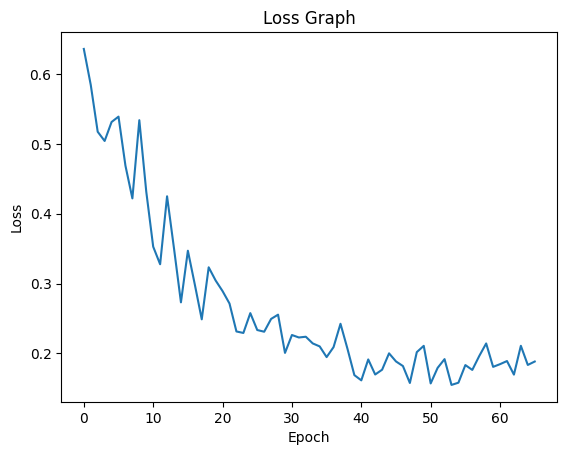

In [ ]:

epoch = list(range(66))
import matplotlib.pyplot as plt
plt.plot(epoch,Loss_hist)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() 

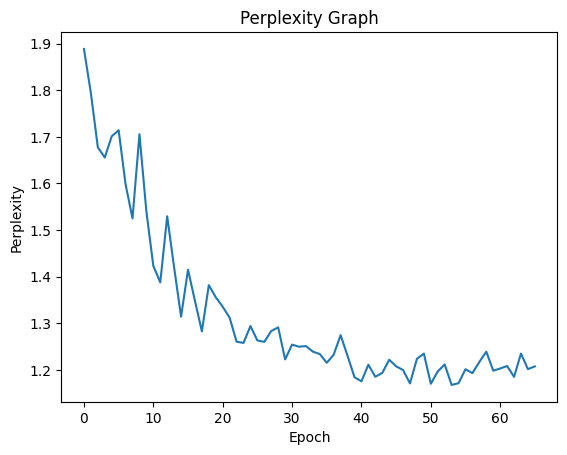

In [ ]:
plt.plot(epoch ,Perplexity_hist)
plt.title('Perplexity Graph')
plt.xlabel('Epoch')
plt.ylabel('Perplexity') 
plt.show() 

In [ ]:
def translate(model, src, max_len=80, custom_sentence=False):
    
    model.eval()
    
    if custom_sentence == True:
        src = tokenize_ja(src)
        src = torch.autograd.Variable(torch.LongTensor([[JA_TEXT.vocab.stoi[tok] for tok in src]])).to(device)
    
    src_mask = (src != input_pad).unsqueeze(-2)
    e_outputs = model.encoder(src, src_mask)

    outputs = torch.zeros(max_len).type_as(src.data)
    outputs[0] = torch.LongTensor([EN_TEXT.vocab.stoi['<sos>']])
    
    for i in range(1, max_len):    
        trg_mask = np.triu(np.ones((1, i, i)), k=1).astype('uint8')
        trg_mask = torch.autograd.Variable(torch.from_numpy(trg_mask) == 0).to(device)

        out = model.out(
            model.decoder(
                outputs[:i].unsqueeze(0),
                e_outputs,
                src_mask,
                trg_mask
            )
        )
        out = F.softmax(out, dim=-1)
        val, ix = out[:, -1].data.topk(1)

        outputs[i] = ix[0][0]
        if ix[0][0] == EN_TEXT.vocab.stoi['<eos>']:
            break

    return ' '.join([EN_TEXT.vocab.itos[ix] for ix in outputs[:i]])

# **Results and Analysis**

We conducted a translation experiment using our model, and the following is our analysis of the translated sentences.

The sentence was successfully translated even without explicitly providing the subject "I" (僕). The results were accurate in capturing the intended meaning.

In [ ]:
translate(model, '駅に行く途中なの。', custom_sentence=True) 

"<sos> I 'm on my way to the station ."

The sentence posed an interesting case. Without providing the subject "I" (僕) and ending the sentence with (。), the translation resulted in an unusual output. The correct translation should be "On the way to the station." Based on our analysis, we observed that our model predicts more accurately when a proper sentence-ending dot is included or when a subject is provided.

In [ ]:
translate(model, '駅に行く途中なの', custom_sentence=True) 

'<sos> on my way to the station .'

The two random sentences were provided to the model out of curiosity, and our model successfully translated them accurately. This indicates the model's ability to handle various sentence inputs and produce meaningful translations.

In [ ]:
translate(model, '日本語は難しいと思います', custom_sentence=True) 

'<sos> I think that Japanese is difficult .'

In [ ]:
translate(model, '英語は簡単です' , custom_sentence=True)

'<sos> English is easy .'

# **BLEU Score**

We could achieve a BLEU score of 7.79 for our model for Japanese to English Neural Machine Translation which is equal to the State of the art BLEU score.

In [ ]:
test_df = pd.read_csv('test.csv') 

In [ ]:
test_df

,Japanese,English
0,開敷華王－かいふけおう,Kaifukeo
1,毎朝早起きするのを習慣にしている。,I make it a rule to get up early in the morning.
2,彼は彼女と賭けをした。,He made a bet with her.
3,サダム・フセイン,Saddam Husayn
4,茶室安楽庵,Anrakuan Tea House
...,...,...
22887,大寄せの茶会,a tea ceremony party with a number of attendants
22888,全く同じ辞書を持ってるよ。,I have exactly the same dictionary.
22889,荻野真,OGINO Makoto
22890,彼が働く必要はない。,There is no need for him to work.


In [ ]:
import warnings
warnings.filterwarnings('ignore') 

In [ ]:
data_length = len(test_df["English"]);
total_score = 0;

for i in range(data_length):
  reference = tokenize_en(test_df["English"][i]);
  candidate = tokenize_en(translate(model, test_df["Japanese"][i] , custom_sentence=True));
  candidate = candidate[3:]
  score = sentence_bleu(reference, candidate)
  total_score += score;

In [ ]:
print(f'BLEU score = {(total_score/data_length)*100}') 

BLEU score = 7.795914978111662e-155
